Instructions
-------------
This notebook goes from micro-variable 1D input -- 1D output data to macro-level states. The data comes from Pair 20 used in the Causal Pairs challenge data, created at the Max-Planck-Institute for Biological Cybernetics. The x-coordinates correspond to latitude (of German weather stations) and y-coordinates to temperature. 

To use your own data, you only need to modify the "The Dataset" cell -- substitute your own data for our X and Y arrays. Note: THIS WILL NOT WORK ON MULTI - DIMENSIONAL INPUTS / OUTPUTS! (Although it wouldn't be super hard to modify it to work.)

If you like, you can also experiment with neural net training in the "Learning P(Y | X)" cell. Make sure the validation error converges. Feel free to experiment with other neural net architectures if you're comfortable with Lasagne! If your PC has a GPU, this code will automatically use it. If you have no GPU and the training is slow, you can stop training at any time by pressing ctrl+c (on Linux) and the script will load the best network learned during training on the next step (during training, the current-best net is saved to a file).

Good Luck!

Krzysztof Chalupka, Caltech, July 2016.

In [1]:
""" This cell sets up the Python environment. Make sure you have the following packages installed:
numpy
matplotlib
theano
lasagne
sklearn
All of them are available through $ pip install [package_name]. 
This is only tested on Ubuntu Linux, I've heard Theano is a pain to get working on Windows.
"""
import sys

sys.setrecursionlimit(1000000) # Otherwise, joblib won't save deep nets.

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


The Dataset
-----------

The following code loads our data into the correct format:
* X -- numpy array of size (n_datapoints, n_input_dim). Each row corresponds to one input value.
* Y -- numpy array of size (n_datapoints, n_output_dim). Each row is one output value.

In our case, each row of X is a (flattened) map of Pacific zonal wind strength, and each row of Y a (flattened) map of Pacific water temperature over the same region. In our case, n_input_dim == n_output_dim, but this need not be the case at all.

In [6]:
import numpy as np
# Load the data. 
## PLUG YOUR OWN DATA HERE. 'coords' is only needed to display climate maps. Your data
## can only contain X and Y arrays.
X, Y = joblib.load('pair20.pkl')

# Create a randomized, normalized training and validation set.
shuffled_ids = np.random.permutation(X.shape[0])
X_tr = X[shuffled_ids[:int(X.shape[0]*.9)]]
Y_tr = Y[shuffled_ids[:int(Y.shape[0]*.9)]]
X_ts = X[shuffled_ids[int(X.shape[0]*.9):]]
Y_ts = Y[shuffled_ids[int(Y.shape[0]*.9):]]
x_scaler = StandardScaler().fit(X_tr)
y_scaler = StandardScaler().fit(Y_tr)
X_tr = x_scaler.transform(X_tr)
X_ts = x_scaler.transform(X_ts)
Y_tr = y_scaler.transform(Y_tr)
Y_ts = y_scaler.transform(Y_ts)

Learning P(Y | X)
--------------------
The first step of Causal Feature Learning (CFL) is to cluster x's according to P(Y | x). In this cell, we use a Mixture Density Network (Bishop 1995) implemented in Lasagne/Theano to learn these conditionals. Since our data are 1d, we can visualize the conditionals in a nice plot. As seen, we approximate the true density by a smoothly-varying (with x) mixture of Gaussians. 

NOTE: The neural net training will stop after 1000 epochs. It should take several seconds on a GPU. If you're working on a CPU machine and the training is slow, you can stop it any time by sending a "kernel interrupt" signal to your IPython Notebook. The so-far-best network will have been saved by the program.

Validation loss before training: 50.34532547.
Starting training...
Epoch 999. Valid loss 38.01 [32.73]. Train loss 22.53.

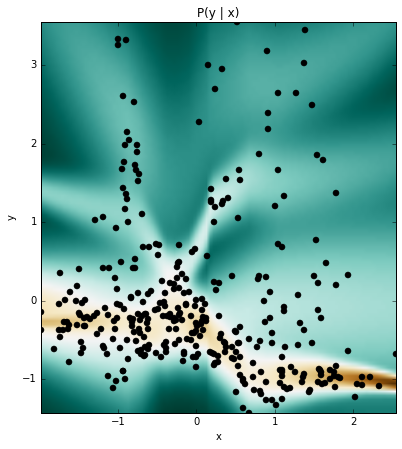

In [71]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import core_ml
reload(core_ml)
from core_ml import train_mixture_density_network
from core_ml import eval_gaussian_mixture

## NOTE: If on the example data your best valid loss (you'll see it printed 
## in square brackets during training) is more than 33, you fell into a 
## local minimum -- repeat the training.
train_mixture_density_network(X_tr, Y_tr, X_ts, Y_ts, 
                              save_fname='nn_params/net', n_components=4)
net = joblib.load('nn_params/net')
predictor = theano.function([lasagne.layers.get_all_layers(net)[0].input_var], 
                            lasagne.layers.get_output(net, deterministic=True),
                            allow_input_downcast=True)
density = np.array(
    [eval_gaussian_mixture(predictor(np.array([[x]])), 
                           density_grid=np.linspace(Y.min(), Y.max(),100))
     for x in np.linspace(X.min(), X.max(), 100)])

plt.figure(figsize=(7,7), facecolor='white')
plt.hold('on')
plt.imshow(density.T, origin='low', extent=[X.min(), X.max(), Y.min(), Y.max()],
           cmap='BrBG_r', norm=colors.PowerNorm(gamma=1./3.))
plt.plot(X.flatten(), Y.flatten(), 'ko')
plt.xlim([X.min(), X.max()])
plt.ylim([Y.min(), Y.max()])
plt.xlabel('x')
plt.ylabel('y')
plt.title('P(y | x)')

Finding the Observational Partition of X
-----------------------------------------
Finding the observational partition of X amounts to clustering the X data according to P(Y | X). That is, we put two x's in the same bucket if the neural net we trained maps them to the same values. Note that we simply set the number of causal classes to 5 by hand. There are more principled method of choosing the number of causal states in our Visual Causal Feature Learning article.

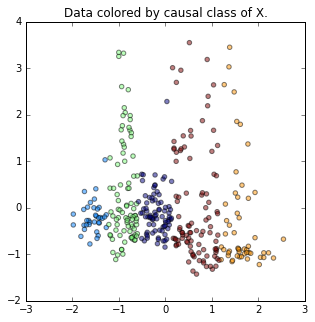

In [72]:
""" Discover the observational classes of X. """
from sklearn.cluster import KMeans
N_CLASSES = 5
p_y_x = predictor(X)
x_lbls = KMeans(n_clusters=N_CLASSES, n_init=10, n_jobs=-1).fit_predict(p_y_x)
plt.figure(figsize=(5,5), facecolor='white')
plt.scatter(X, Y, c=x_lbls, alpha=.5)
plt.title('Data colored by causal class of X.')

Finding the Observational Partition of Y
---------------------------------------------
To find the partition of Y, we want to put together all y1 and y2 if P(y1 | x) == P(y2 | x) for each x. Again, we set the number of states to 5 by hand.

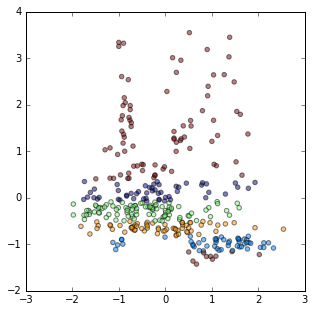

In [73]:
""" Discover the observational classes of Y. """
y_ftrs = np.array([eval_gaussian_mixture(predictor(np.array([[x]])), density_grid=Y.flatten())
           for x in X.flatten()]).T
y_lbls = KMeans(n_clusters=N_CLASSES, n_init=10, n_jobs=-1).fit_predict(y_ftrs)

plt.figure(figsize=(5,5), facecolor='white')
plt.title('Data colored by the causal class of Y')
plt.scatter(X, Y, c=y_lbls, alpha=.5)